## Table of Contents

1. [Obtaining the Data](#obtaining-the-data)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
3. [Obtaining Main Color of Pokemon](#obtaining-main-color-of-pokemon)
4. [Building a Predictive Model](#building-a-predictive-model)
5. [Conclusion](#Conclusion)

# Obtaining the Data

Before we can analyze data, we first need to obtain something to analyze. There are a lot of great websites that have the information we need, but for this example we'll be going with [Pokemon Database](https://www.pokemondb.net/pokedex/all). Instead of manually iterating through every single page writing down information about their battle stats, a much more efficient way would be to program a webscraper to automate the data collection. We'll be using Python's `resquest` module to send requests to the website and `BeautifulSoup` to parse the data. Let's begin. 

In [ ]:
# import modules for web scraping
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm # add a progress bar for loops

In [ ]:
main_page = requests.get('https://pokemondb.net/pokedex/all')
soup = BeautifulSoup(main_page.content, 'html.parser')

poke_html_list = soup.select('a.ent-name')
poke_list = []
for poke in poke_html_list:
    if poke['href'] not in poke_list: poke_list.append(poke['href'])

In [ ]:
pokemon_list = []
base_stats = []
type_ = []
evo_stage_list = []

for pokemon in tqdm(poke_list):
    page2 = requests.get('https://pokemondb.net' + pokemon)
    soup2 = BeautifulSoup(page2.content, 'html.parser')
    
    stats = soup2.select('table.vitals-table tbody td.cell-num') #selecting all the numbers
    stat_numbers = []
    for index, i in enumerate(stats):
        if (index)%3 ==0: stat_numbers.append(i.text) #every 3 is one of the main stats
    base_stats.append(stat_numbers)
    
    
    types = soup2.select('table.vitals-table tbody tr a.type-icon')
    ind_type = []
    for i in types:
        ind_type.append(i.text)
    type_.append(list(set(ind_type)))

    evo_list = soup2.select('div.infocard a.ent-name')
    evo_list = list(map(str, evo_list))
    evo_stage = [stage for stage, item in enumerate(evo_list) if pokemon+'"' in item]
    # if the list is empty, then that means there is no other evolutions, so just assign it '1'
    try:
        evo_stage_list.append(evo_stage[0] + 1)
    except:
        evo_stage_list.append(1)

In [ ]:
hp = []
att = []
defs = []
spatt = []
spdef = []
spe = []

for i in base_stats:
    hp.append(i[0])
    att.append(i[1])
    defs.append(i[2])
    spatt.append(i[3])
    spdef.append(i[4])
    spe.append(i[5])
    
first_type = []
for i in type_:
    first_type.append(i[0])

import pandas as pd
dataf = pd.DataFrame({'pokemon': [i.replace('/pokedex/', '') for i in poke_list],
                      'hp': hp,
                      'att': att,
                      'defs': defs,
                      'spatt': spatt,
                      'spdef': spdef,
                      'spe': spe,
                      'type': first_type,
                      'types': type_,
                     'evo_stage': evo_stage_list})

dataf = dataf[['pokemon']+list(dataf.drop('pokemon', axis=1).columns)] # moving pokemon column to the front
dataf.to_csv('original_data.csv', index=False)

This program iterates through all of the individual pokemon's unique page and collects their HP, Attack, Defense, Sp. Attack, Sp. Def, Speed, Types, and their Evolution Stage. Once the information is collected, the data is passed into a pandas `DataFrame` object so we get an organized and informative dataframe! This is what the first 10 rows look like:

In [19]:
dataf.head(10)

,pokemon,hp,att,defs,spatt,spdef,spe,type,types,evo_stage,r,g,b,color
0,bulbasaur,45,49,49,65,65,45,Grass,"['Grass', 'Poison']",1,98,153,119,"rgb(98, 153, 119)"
1,ivysaur,60,62,63,80,80,60,Grass,"['Grass', 'Poison']",2,95,133,133,"rgb(95, 133, 133)"
2,venusaur,80,82,83,100,100,80,Grass,"['Grass', 'Poison']",3,98,113,107,"rgb(98, 113, 107)"
3,charmander,39,52,43,60,50,65,Fire,['Fire'],1,188,138,97,"rgb(188, 138, 97)"
4,charmeleon,58,64,58,80,65,80,Fire,['Fire'],2,191,102,84,"rgb(191, 102, 84)"
5,charizard,78,84,78,109,85,100,Fire,"['Fire', 'Flying', 'Dragon']",3,146,130,96,"rgb(146, 130, 96)"
6,squirtle,44,48,65,50,64,43,Water,['Water'],1,110,151,164,"rgb(110, 151, 164)"
7,wartortle,59,63,80,65,80,58,Water,['Water'],2,85,106,138,"rgb(85, 106, 138)"
8,blastoise,79,83,100,85,105,78,Water,['Water'],3,110,109,115,"rgb(110, 109, 115)"
9,caterpie,45,30,35,20,20,45,Bug,['Bug'],1,141,152,90,"rgb(141, 152, 90)"


The data is formatted such that the columns represent the different stats, types, and evolution stage while each row represents a different pokemon. This convenient `DataFrame` structure will allow us easily perform our analyses. Now that the computer has done all the hard work of collecting the data, let's dive in!

# Exploratory Data Analysis

In [1]:
# importing our data exploration modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams.update({'font.size': 20}) # to increase matplotlib's font size
sns.set_style("darkgrid") # set plot styling

We'll be using `pandas` for all of our data manipulation needs. For visualizations, we'll be using `seaborn`, which is a statisical data visualization library that uses `matplotlib`. To pass the data into `seaborn`, we first need to "melt" the data so that it is in *long* format rather than *wide*. This means that there will be a single column called `stats` rather than having each stat as a separate column.

In [2]:
dataf = pd.read_csv('original_data.csv')
dataf.loc[dataf.evo_stage>3, 'evo_stage'] = 3
dataf.pokemon = dataf.pokemon.str.lower()
dataf_stats = dataf.drop(['types'], axis=1)

dataf_long_stats = pd.melt(dataf_stats, id_vars = ['pokemon','type','evo_stage'], var_name = 'stats')
dataf_long_stats.head(10)
print('The shape of the original dataframe is: ', dataf.shape)
print('The shape of the melted dataframe is: ', dataf_long_stats.shape)

,pokemon,type,evo_stage,stats,value
0,bulbasaur,Grass,1,hp,45
1,ivysaur,Grass,2,hp,60
2,venusaur,Grass,3,hp,80
3,charmander,Fire,1,hp,39
4,charmeleon,Fire,2,hp,58
5,charizard,Fire,3,hp,78
6,squirtle,Water,1,hp,44
7,wartortle,Water,2,hp,59
8,blastoise,Water,3,hp,79
9,caterpie,Bug,1,hp,45


The shape of the original dataframe is:  (807, 10)
The shape of the melted dataframe is:  (4842, 5)


We can see that the new dataframe is 807*6=4842. Instead of having a "wider" dataframe, the dataframe is now "longer," which makes it easier to perform aggregate computations and visualizations. First, let's see the average value of each stat using `pivot_table`.

In [3]:
df_agg = dataf_long_stats.groupby('stats')
df_agg.value.agg([np.mean, np.std])

,mean,std
stats,,
att,76.210657,29.644590
defs,71.602230,29.611741
hp,68.748451,26.032808
spatt,69.610905,29.567768
spdef,69.889715,27.155402
spe,65.830235,27.736838


Now, let's see the distributions of each stat with boxplots.

Text(0.5,1,'Boxplot of Stats')

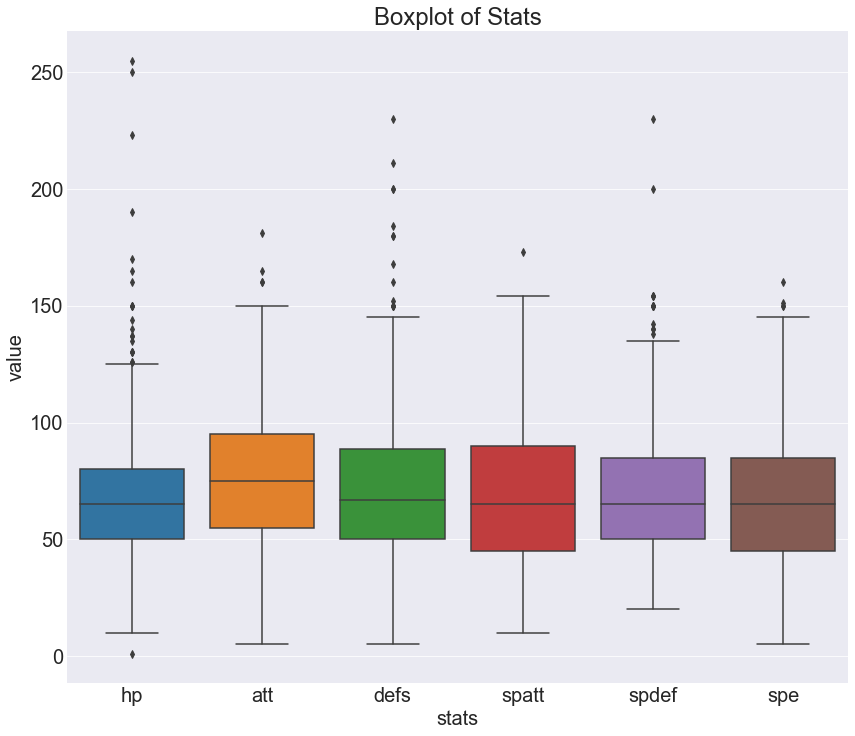

In [6]:
plt.figure(figsize=(14,12))
plt.rcParams.update({'font.size': 20})
sns.boxplot(x='stats', y='value', data = dataf_long_stats)
plt.title('Boxplot of Stats')

Doesn't seem like there's anything *toooo* interesting here. The medians for each stat appears to be around 70-80. There does seem to be an abnormally large amount of outliers for HP. Let's take a look at how evolution stage affects stats using a swarmplot. Since the visual will be very messy with all the pokemon, I decided to take a look at the first 200.

Text(0.5,1,'Swarmplot of Stats with Evolution')

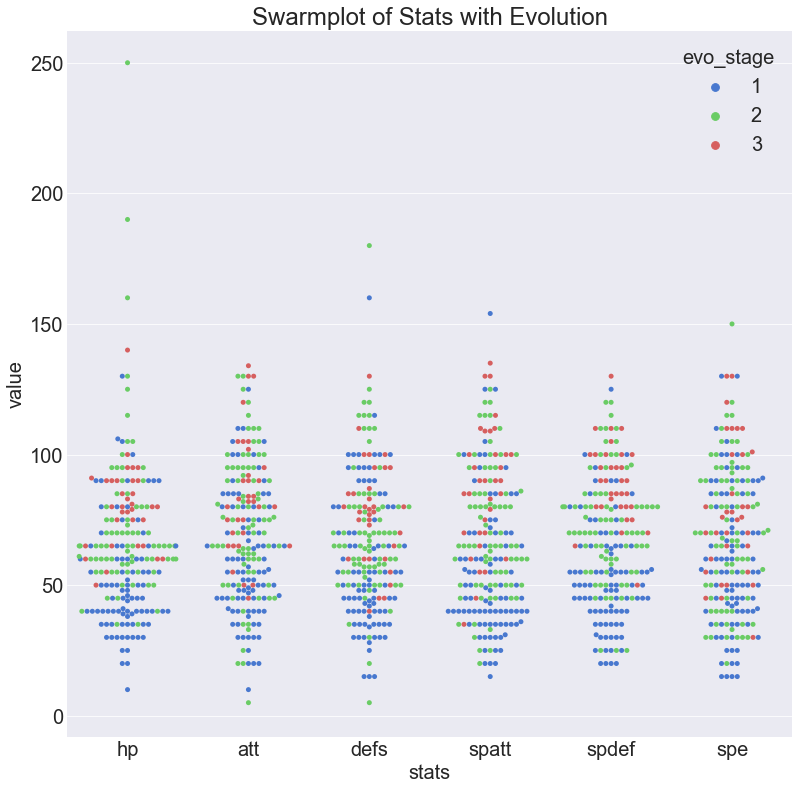

In [7]:
# script to extract first 200 pokemon
indexes = []
count = 0
for i in range(dataf_long_stats.shape[0]):
    if count <= 200:
        indexes.append(i)               
    count += 1               
    if i % 807 == 0:
        count = 0    
# drawing the swarmplot
plt.figure(figsize=(13,13))
sns.swarmplot(x='stats', y= 'value', hue = 'evo_stage', 
              data = dataf_long_stats.iloc[indexes], palette = 'muted' )
plt.title('Swarmplot of Stats with Evolution')

This graph tells us a few things that we probably already knew. First of all, we can see that the first stage comprises most of the pokemon and tends to have the lowest stats. Next, we see that the third stage are the fewest but they tend to be higher up on the graph. The second stage is intermediate in both count and stat values. 

Let's see what kind of role type plays on stats. First let's take a look at the numbers by aggregating the data with a pivot table.

stats,att,defs,hp,spatt,spdef,spe
type,,,,,,
Bug,57.575000,66.625000,50.275000,41.575000,57.750000,50.150000
Dark,84.800000,61.200000,62.000000,84.800000,68.700000,78.200000
Dragon,93.678571,78.750000,79.714286,82.964286,80.392857,70.357143
Electric,69.454545,56.515152,63.181818,79.424242,65.606061,82.242424
Fairy,63.333333,71.361111,64.833333,79.000000,87.500000,63.361111
Fighting,99.227273,73.318182,74.113636,60.227273,69.386364,72.568182
Fire,80.500000,65.515625,68.328125,87.578125,70.218750,75.171875
Flying,76.157895,69.070175,73.087719,80.210526,74.789474,83.982456
Ghost,72.142857,87.428571,56.142857,79.285714,88.428571,59.857143


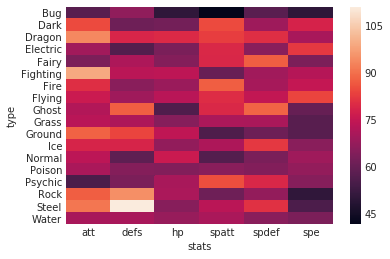

In [7]:
df_agg = pd.pivot_table(dataf_long_stats.drop('evo_stage',axis=1), 
                        index='type', columns = 'stats', values='value')
df_agg
sns.heatmap(df_agg)

It's a bit hard to see any trends with just numbers and this heatmap... Let's see how these numbers play out with other visuals. This will be a barplot that describes the distribution of means for each of the stats.

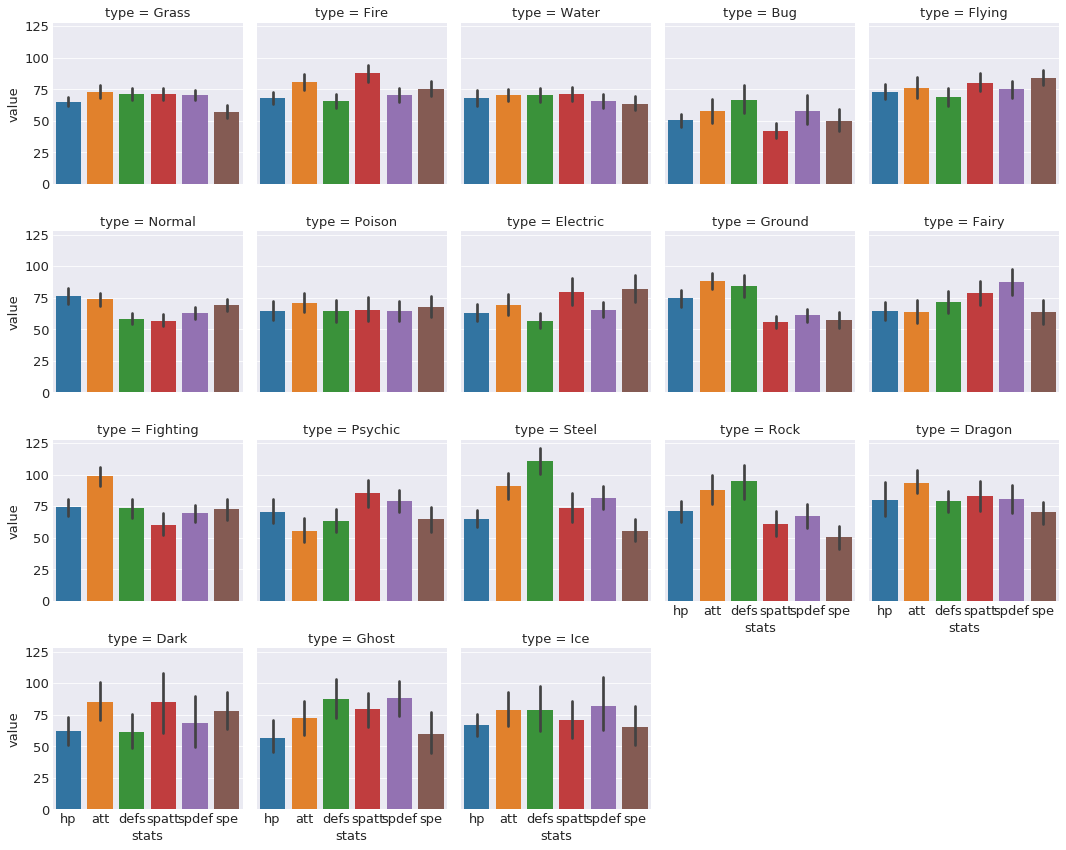

In [8]:
plt.rcParams.update({'font.size': 13})
g = sns.factorplot(x='stats', y = 'value', data = dataf_long_stats,
                   col = 'type', col_wrap=5, kind = 'bar', size = 3)

A bit hard to see, but there are some interesting trends. For example, bug type pokemon seem to have lower overall. Steel and rock types have strikingly high defense but very low speed. 

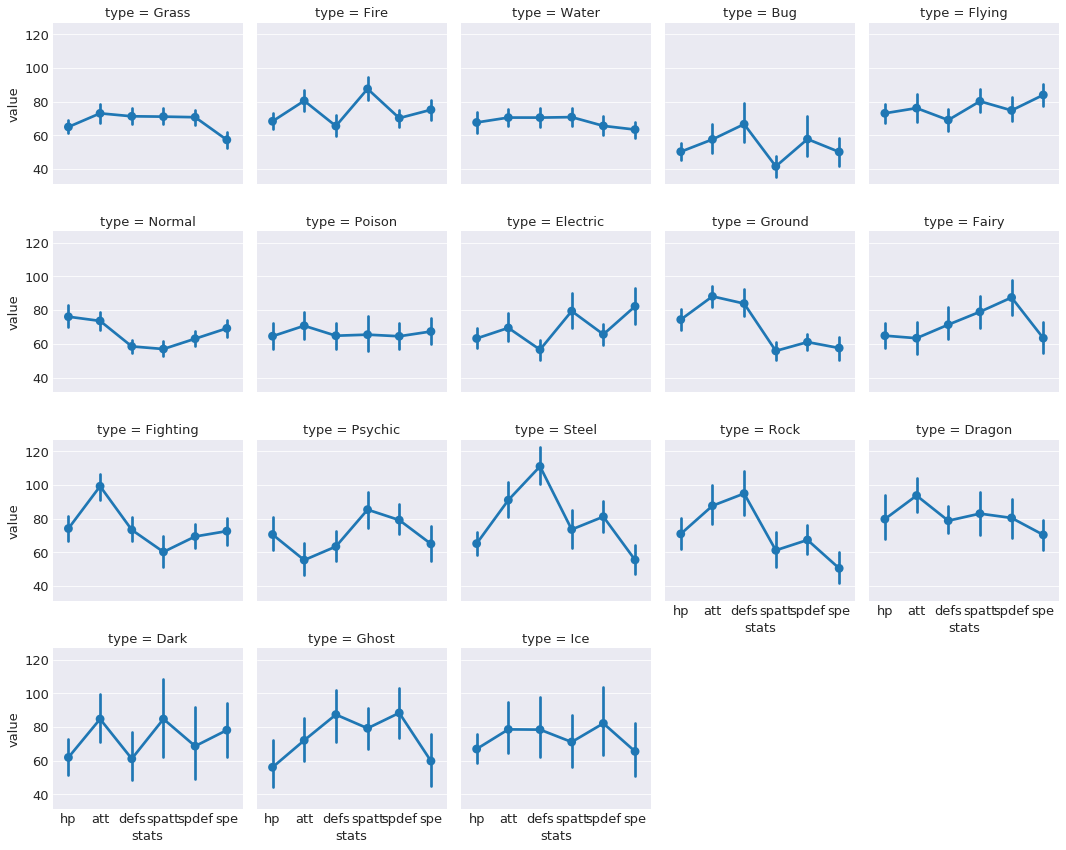

In [9]:
plt.rcParams.update({'font.size': 13})
g = sns.factorplot(x='stats', y = 'value', data = dataf_long_stats,
                   col = 'type', col_wrap=5, kind = 'point', size = 3)

A similar visual, except using points rather than bar. This allows us to much more easily see the distribution of stats per type. Perhaps we can build a model that can learn these differences...

# Obtaining the Main Color of each Pokemon

In [ ]:
import requests
import PIL
import io
import numpy as np
import cv2

In [ ]:
# Download all of the pokemon images

poke_col_list = []
for counter, pokemon in enumerate(poke_list):
    page2 = requests.get('https://pokemondb.net' + pokemon)
    soup2 = BeautifulSoup(page2.content, 'html.parser')

    img_link = soup2.select('div.col.desk-span-4.lap-span-6.figure img')[0]['src']
    #print(img_link)
    

    img = requests.get(img_link, stream=True)
    
    img_name = 'images' + pokemon.replace('/pokedex', '') + '.jpg' 
    with open(img_name, 'wb') as handler:
        handler.write(img.content)
        #print('Saving', pokemon)
        print(str(counter+1)+ '/'+ str(len(poke_list)) + ' saved.')    

I will be defining the "main color" of the pokemon as the average of it's color. Each image contains the pokemon and a white background. If I take just the average of the entire image, it will be too white because of the white background. To avoid this problem, I used a k-means function to compute 2 clusters. One cluster center will correspond to the average of the white background while the other cluster center will correspond to the average of the pokemon color.

In [ ]:
from os import listdir
poke_img_files = listdir('images')

poke_col_list = []
for poke_img in tqdm(poke_img_files):
    img = PIL.Image.open('images/'+ poke_img)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))


    b,g,r = cv2.split(res2)
    frame_rgb = cv2.merge((r,g,b))
    img_name = 'new_images/' + poke_img
    pil_img = PIL.Image.fromarray(frame_rgb, "RGB")
    pil_img.save(img_name)
    #print('Saving', poke_img)
    
    # extracting the two colors
    two_colors = []
    big_list = []
    res3 = res2.tolist()
    for i in res3:
        big_list.extend(i)
    for i in big_list:
        in_list = i in two_colors
        if in_list == False: two_colors.append(i)
    # the color that is farther away from 250 (white) is probably the pokemon's dominant color

    main_color = [sorted(two_colors)[0]] # each array is (BGR) instead of (RGB)
    poke_col_list.append(main_color)

In [ ]:
poke_col_list_flat = []
for i in poke_col_list:
    for j in i:
        poke_col_list_flat.append(j)
b, g, r = zip(*poke_col_list_flat) # create new lists that correspond to blue, green, and red channel
color_df = pd.DataFrame({'r':r, 'g': g, 'b': b,
                         'pokemon': [item.replace('.jpg', '') for item in poke_img_files]})

# adding this column 'color' because plotly requires color to be in that format
color_df['color'] = 'rgb(' + color_df.r.map(str) + ', ' + color_df.g.map(str) + ', ' + color_df.b.map(str) + ')'

dataf = pd.merge(dataf, color_df, on = 'pokemon') # merging the color dataframe with the original dataframe by 'pokemon' column
dataf.shape
dataf.head()

dataf.to_csv('data_w_color.csv', index= False)

Visualizing the the colors

In [10]:
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

In [11]:
dataf = pd.read_csv('data_w_color.csv')

trace1 = go.Scatter3d(
    x=dataf['r'],
    y=dataf['g'],
    z=dataf['b'],
    mode='markers',
    marker=dict(
        color=dataf['color'],
        size=5,
        line=dict(
            color= dataf['color'],
            width=0.5
        ),
        opacity=0.8
    ),
    text = dataf.pokemon
)

data = [trace1]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene = dict(
        xaxis = dict(title = 'Red'),
        yaxis = dict(title = 'Green'),
        zaxis = dict(title = 'Blue')
    ),
    paper_bgcolor='rgba(0,0,0,0)'
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

Interesting results... but this doesn't tell us much besides the color distribution. What's more important would be to include type into visual. Now, keeping the same points on this graph, but changing each point's color to correspond to its type. This will allow us to see the relationship between color and type. First, we need to create a new color scheme that corresponds to the colors that we're more familiar with.

In [12]:
color_type_dict = {}

# obtaining this color palette from bulbapedia.com
color_type_dict = {'Grass': 'rgb(120,200,80)',
                   'Fire': 'rgb(240,128,48)',
                   'Water': 'rgb(104,144,240)',
                   'Bug': 'rgb(168,184,32)',
                   'Normal': 'rgb(168,168,120)',
                   'Poison': 'rgb(160,64,160)',
                   'Electric': 'rgb(248,208,48)',
                   'Ground': 'rgb(224,192,104)',
                   'Fairy': 'rgb(238,153,172)',
                   'Fighting': 'rgb(192,48,40)',
                   'Psychic': 'rgb(248,88,136)',
                   'Rock': 'rgb(184,160,56)',
                   'Ghost': 'rgb(112,88,152)',
                   'Ice': 'rgb(152,216,216)',
                   'Dragon': 'rgb(112,56,248)',
                   'Flying': 'rgb(168,144,240)',
                   'Dark': 'rgb(112,88,72)',
                   'Steel': 'rgb(184,184,208)'
}    

# mapping these colors to each pokemon    
color_type = []
for i in range(0,len(dataf)):
    p_type = dataf.iloc[i].type
    color_item = color_type_dict[p_type]
    col = color_item
    color_type.append(col)
    
dataf['color_type'] = color_type

In [13]:
trace2 = []

for col_type in np.unique(color_type):
    dataf_type_subset = dataf.loc[dataf.color_type == col_type]
    trace2.append(
        go.Scatter3d(
        x=dataf_type_subset['r'],
        y=dataf_type_subset['b'],
        z=dataf_type_subset['g'],
        mode='markers',
        marker=dict(
            color=dataf_type_subset['color_type'],
            size=5,
            line=dict(
                color= dataf_type_subset['color_type'],
                width=0.5
            ),
            opacity=0.8
        ),
        text = dataf_type_subset['type'],
        name = dataf_type_subset.type.iloc[1]
        )
    )

    
data2 = [trace2]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene = dict(
        xaxis = dict(title = 'Red'),
        yaxis = dict(title = 'Blue'),
        zaxis = dict(title = 'Green')
    ),
    paper_bgcolor='rgba(0,0,0,0)'
)

fig2 = go.Figure(data=trace2, layout=layout)
py.iplot(fig2, filename='simple-3d-scatter2')

The pokemon are in the same space as the previous graph. The difference here is that the color of the points changed to represent the pokemon's type. Since there are so many different types in such a small plot, it's difficult to see clear clusters. However, there are distinct clusters; for example, you can see that fire types and water types are on opposite ends. Just out of curiousity I'll try different machine learning methods to see how useful of a feature color is.

# Building a Predictive Model

Just a reminder, we'll be trying to predict a pokemon's type by using their base stats, evolution stage, and color.
The first thing that should be done is to establish a benchmark to beat. This benchmark will be the accuracy of a "dumb" model that predicts only the most frequent type. Since the most frequent type is water, this "dumb" model will have an accuracy of about 116/807 $\approx$ 14%. 

Usually before feeding data into machine learning algorithms, the data must be preprocessed and formatted correctly to achieve the best results. However, it's a good thing that the data is already in the perfect format that we need, so no further preprocessing will be necessary. 

We'll split up the data into a training set (80%) and a validation set (20%) to see how well the model generalizes to data it hasn't seen before.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

# xgboost causing warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
dataf = pd.read_csv('data_w_color.csv')

# first drop all unnecessary variables
dataf_clean = dataf.drop(['types', 'color', 'pokemon'], axis=1)
X = dataf_clean.drop('type', axis=1) # feature matrix
y = dataf_clean.type # target vector

In [5]:
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123, stratify = y)
print('The shape of X_train is ', X_train.shape)
print('The shape of y_train is ', y_train.shape)
print('The shape of X_test is ', X_test.shape)
print('The shape of y_test is ', y_test.shape)

The shape of X_train is  (645, 10)
The shape of y_train is  (645,)
The shape of X_test is  (162, 10)
The shape of y_test is  (162,)


Let's first try out a few classical machine learning algorithms to see which ones perform well by looking at their cross validation scores

In [17]:
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(("KNeighborsClassifier", KNeighborsClassifier(n_neighbors=10)))
models.append(("RandomForestClassifier", RandomForestClassifier(n_estimators=200,
                                                                criterion='gini',
                                                                    max_features=3)))
models.append(('XGBoost', XGBClassifier(learning_rate=0.05, n_estimators=100,
                                       max_depth= 5)))

results = []
names = []
for name,model in models:
    result = cross_val_score(model, X_train, y_train, cv=5)
    names.append(name)
    results.append(result)

mean_results = []
sd_results = []
for model in results:
    mean_results.append(model.mean())
    sd_results.append(model.std())

results_df = pd.DataFrame({'Model': names,
              'Mean Classification Rate': mean_results,
              'Standard Deviation': sd_results
             })
results_df.sort_values(by = 'Mean Classification Rate', ascending=False) # returning sorted dataframe

,Model,Mean Classification Rate,Standard Deviation
0,LogisticRegression,0.342986,0.039329
2,RandomForestClassifier,0.304093,0.037466
3,XGBoost,0.263581,0.028925
1,KNeighborsClassifier,0.254184,0.033099


Seems that a simple logistic regression has the highest cross-validation score. Let's see how they do on the held-out validation set.

In [18]:
results = []
names = []
for name, model in models:
    model_fit = model.fit(X_train, y_train)
    pred = model_fit.predict(X_test)
    result = accuracy_score(pred, y_test)
    results.append(result)
    names.append(name)

results_df = pd.DataFrame({
    'Model': names,
    'Classification Rate': results
})

results_df.sort_values(by = 'Classification Rate', ascending = False)

,Model,Classification Rate
0,LogisticRegression,0.327160
3,XGBoost,0.296296
1,KNeighborsClassifier,0.290123
2,RandomForestClassifier,0.283951


Indeed, logistic regression performs the best on the validation set. It is slightly lower than the training score, which is to be expected and suggests some overfitting. Now let's see how well neural networks perform on this dataset!

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

import keras.backend as K

In [7]:
K.clear_session()

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)


def build_nnet():
    nnet = Sequential()
    nnet.add(Dense(512, kernel_initializer= 'normal', input_shape = (10,), activation = 'relu'))
    nnet.add(Dropout(0.5))
    nnet.add(Dense(512, kernel_initializer= 'normal',activation = 'relu'))
    nnet.add(Dropout(0.3))


    nnet.add(Dense(18, activation = 'softmax'))
    nnet.compile(Adam(lr=0.001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
    return nnet

y_train_cat = pd.get_dummies(y_train)
y_test_cat = pd.get_dummies(y_test)
nnet = KerasClassifier(build_fn = build_nnet, epochs = 100, verbose =0)

In [18]:
cv_score = cross_val_score(nnet, X_train, y_train_cat)
print('The cross-validation scores for this neural network are: ', cv_score)
print('The average cross-validation score for this neural network is: ', cv_score.mean())

The cross-validation scores for this neural network are:  [0.31627907 0.31162791 0.3627907 ]
The average cross-validation score for this neural network is:  0.3302325581395349


In [10]:
nnet.fit(X_train, y_train_cat, epochs = 100, verbose=1, batch_size=100, validation_split = 0.2)

pred = nnet.predict(X_test)
#pred
accuracy_score(np.asarray(y_test_cat).argmax(axis=1),pred)

Train on 516 samples, validate on 129 samples
Epoch 1/100
516/516 [==============================] - 0s 511us/step - loss: 13.7788 - acc: 0.0891 - val_loss: 13.3860 - val_acc: 0.1008
Epoch 2/100
516/516 [==============================] - 0s 63us/step - loss: 13.2896 - acc: 0.1240 - val_loss: 14.3508 - val_acc: 0.1085
Epoch 3/100
516/516 [==============================] - 0s 48us/step - loss: 13.7236 - acc: 0.1395 - val_loss: 14.3688 - val_acc: 0.1085
Epoch 4/100
516/516 [==============================] - 0s 57us/step - loss: 12.9963 - acc: 0.1609 - val_loss: 13.2170 - val_acc: 0.1473
Epoch 5/100
516/516 [==============================] - 0s 53us/step - loss: 13.5943 - acc: 0.1260 - val_loss: 13.1866 - val_acc: 0.1628
Epoch 6/100
516/516 [==============================] - 0s 56us/step - loss: 13.5122 - acc: 0.1376 - val_loss: 13.4828 - val_acc: 0.1395
Epoch 7/100
516/516 [==============================] - 0s 49us/step - loss: 13.2481 - acc: 0.1589 - val_loss: 13.2589 - val_acc: 0.1550
E

0.35185185185185186

# Conclusion

Even though these models didn't yield world-class results, I still think it's quite an impressive improvement over the benchmark. It's highly likely that these variables aren't very good predictors for type. I did try running different models without the color features (not shown) and found that color improves the scores by about 5-10%, showing how important feature engineering is. There are a few things that likely could have improved the results. 
1. We could have collected more data on each pokemon, such as their height and weight, since certain types, such as steel and rock, are more heavier than others, such as grass and bug. 
2. We could have fine-tuned the algorithms' hyperparameters through methods such as random search or grid search.
3. 

Overall, from data collection to exploration to analysis, this was a challenging but fun little experiment for me to practice my data analysis and machine learning skills :).